# Diploma
## Catching Fraud

<pre>
Student: Vladimir Nikiforov
</pre>

Payments are the most digitalized part of the financial industry, making them particularly vulnerable to digital fraud.  
The growth of mobile payments and competition for the best customer experience are pushing banks to reduce the number of verification stages.  
This reduces the effectiveness of the rule-based approach.  
Thus, banks and payment companies are moving to data analysis, machine learning, and AI-driven methods.

Modern fraud detection systems solve a wide range of analytical tasks to detect all fraudulent transactions in payment flows.

***The goal is to use the data to design an ML algorithm to identify fraudsters and conduct necessary actions.***

LOCK_USER - Current transaction is blocked and user’s account is LOCKED. This prevents the user from performing any transactions with their account. Access can only be restored after contacting an agent.  
ALERT_AGENT - Current transaction is not blocked. An alert is sent to a transaction monitoring agent for further review.

## Data
1. countries.csv
	- a table with all alpha-numeric representations of countries. You may need to use this to standardise country codes to one format
2. fraudsters.csv
	- this just holds a list of IDs of users who have been identified as fraudsters for this problem
	- there are others in the users table who are fraudsters, the challenge is to identify them as well
3. users.csv
	- a table of user data
	- **kyc** column indicates the status of the user's identity verification process
	- **terms_version** column indiciates the user's current version of the app
	- **state**
		LOCKED - the user's account is locked and they cannot perform any transactions. If there are transactions for this user, they occurred before the user was LOCKED.  

4. transactions.csv
	- all transactions conducted by users
	- **amount** and **amount_usd** is denominated in integers at the lowest unit. e.g. 5000 USD => 50 USD (because the lowest unit in USD is a cent, w/ 100 cents = 1 dollar)
	- **entry_method** is only relevant for card transactions (CARD_PAYMENT, ATM); you may ignore it for other transactions. The values are:
		misc - unknown
		chip - chip on card
		mags - magstripe on card
		manu - manual entry of card details
		cont - contactless/tap 
		mcon - special case of magstripe & contactless
	- **source** is associated with an external party we use for handling this type of transaction. (e.g. all {CARD_PAYMENT, ATM} use GAIA)
	- **type**
		P2P - sending money internally through the platform (e.g. send money without bank account)
		BANK_TRANSFER - sending money externally to a bank account
		ATM - withdrawing money from an ATM. 

	- **state** 
		COMPLETED - the transaction was completed and the user's balance was changed
		DECLINED/FAILED - the transaction was declined for some reason, usually pertains to insufficient balance 
		REVERTED - the associated transaction was completed first but was then rolled back later in time potentially due to customer reaching out to bank
        
5. currency_details.csv
	- a table with iso codes and exponents for currencies
	- exponent column can be used to convert the integer amounts in the transactions table into cash amounts. (e.g for 5000 GBP, exponent = 2, so we apply: 5000/(10^2) = 50 GBP)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import dateutil

from pprint import pprint

from scipy.stats import pearsonr
import scipy.stats as sts
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
#from sklearn.externals import joblib
import pickle

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class parameters():
    ''' Common class to store all parameters '''
    
    transaction_dataset = './data/transactions.csv'
    country_dataset = './data/countries.csv'
    currency_dataset = './data/currency_details.csv'
    fraudster_dataset = './data/fraudsters.csv'
    user_dataset = './data/users.csv'
    test_user_pkl = './data/test_users.pkl'

    random_state = 7

    n_folds = 3
    test_size = .3
    days_from_max_to_split = None
    
    best_pca_components_number = None
    best_pca = None

    model_pkl = './artifacts/model.pkl'
    dataset_file_name = './data/dataset.csv'
    balanced_dataset_file_name = './data/balanced_dataset.csv'
    
    cols_to_select = ['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'CURRENCY', 'AMOUNT',
                      'STATE', 'MERCHANT_CATEGORY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'HAS_EMAIL',
                      'IS_FRAUDSTER', 'TERMS_VERSION', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE',
                      'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO']
    cat_features = ['ENTRY_METHOD', 'TYPE', 'SOURCE', 'STATE', 'MERCHANT_CATEGORY',
                    'TERMS_VERSION', 'KYC', 'CURRENCY']
    id_features = ['USER_ID','TRN_ID']
    target_feature = 'IS_FRAUDSTER'

### Check all datasets

In [4]:
def load_file(filename, encoding='windows-1251'):
    ''' Function to load csv-file and return dataframe and some statistics '''

    print(f'Loading file: {filename}')
    df = pd.read_csv(filename, encoding='windows-1251')
    print(f'Shape of the dataset: {df.shape}')
    pprint(df.describe())
    pprint(df.head())

    return df

In [5]:
trn_df = load_file(parameters.transaction_dataset)

Loading file: ./data/transactions.csv
Shape of the dataset: (688651, 11)
             AMOUNT
count  6.886510e+05
mean   3.172575e+04
std    2.304381e+06
min    0.000000e+00
25%    4.800000e+02
50%    1.420000e+03
75%    5.000000e+03
max    9.000000e+08
  CURRENCY  AMOUNT      STATE             CREATED_DATE MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED  2017-12-20 12:46:20.294              cafe   
1      EUR    2593  COMPLETED  2017-12-20 12:38:47.232               bar   
2      EUR    1077  COMPLETED  2017-12-20 12:34:39.668               NaN   
3      GBP     198  COMPLETED  2017-12-20 12:45:50.555       supermarket   
4      EUR     990  COMPLETED  2017-12-20 12:45:32.722               NaN   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              AUS         cont  ed773c34-2b83-4f70-a691-6a7aa1cb9f11   
2              CZE         cont  eb349cc1-e986-4bf4-bb75-72280a7b8680  

In [6]:
cntr_df = load_file(parameters.country_dataset)

Loading file: ./data/countries.csv
Shape of the dataset: (226, 5)
          NUMCODE    PHONECODE
count  226.000000   226.000000
mean   433.628319   531.371681
std    251.971451   648.237826
min      4.000000     0.000000
25%    219.000000   220.250000
50%    432.000000   354.500000
75%    645.250000   686.750000
max    894.000000  7370.000000
  CODE            NAME CODE3  NUMCODE  PHONECODE
0   AF     Afghanistan   AFG        4         93
1   AL         Albania   ALB        8        355
2   DZ         Algeria   DZA       12        213
3   AS  American Samoa   ASM       16       1684
4   AO          Angola   AGO       24        244


In [7]:
cur_df = load_file(parameters.currency_dataset)

Loading file: ./data/currency_details.csv
Shape of the dataset: (184, 3)
         EXPONENT
count  184.000000
mean     1.961957
std      1.189052
min      0.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      8.000000
   CCY  EXPONENT  IS_CRYPTO
0  AED         2      False
1  AFN         2      False
2  ALL         2      False
3  AMD         2      False
4  ANG         2      False


In [8]:
fraud_df = load_file(parameters.fraudster_dataset)

Loading file: ./data/fraudsters.csv
Shape of the dataset: (298, 1)
                                     USER_ID
count                                    298
unique                                   298
top     840a2f6a-b344-4e6b-84fe-ff27531f3125
freq                                       1
                                USER_ID
0  5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1  848fc1b1-096c-40f7-b04a-1399c469e421
2  27c76eda-e159-4df3-845a-e13f4e28a8b5
3  a27088ef-9452-403d-9bbb-f7b10180cdda
4  fb23710b-609a-49bf-8a9a-be49c59ce6de


In [9]:
user_df = load_file(parameters.user_dataset)

Loading file: ./data/users.csv
Shape of the dataset: (9944, 11)
         HAS_EMAIL   BIRTH_YEAR  FAILED_SIGN_IN_ATTEMPTS
count  9944.000000  9944.000000              9944.000000
mean      0.946702  1983.553298                 0.008045
std       0.224639    11.350379                 0.129737
min       0.000000  1927.000000                 0.000000
25%       1.000000  1978.000000                 0.000000
50%       1.000000  1986.000000                 0.000000
75%       1.000000  1992.000000                 0.000000
max       1.000000  2000.000000                 6.000000
                                     ID  HAS_EMAIL   PHONE_COUNTRY  \
0  1872820f-e3ac-4c02-bdc7-727897b60043          1  GB||JE||IM||GG   
1  545ff94d-66f8-4bea-b398-84425fb2301e          1  GB||JE||IM||GG   
2  10376f1a-a28a-4885-8daa-c8ca496026bb          1              ES   
3  fd308db7-0753-4377-879f-6ecf2af14e4f          1              FR   
4  755fe256-a34d-4853-b7ca-d9bb991a86d3          1  GB||JE||IM||GG   

  

Users for final test

In [10]:
#test_users = joblib.load(parameters.test_user_pkl)
test_users = pickle.load(open(parameters.test_user_pkl,'rb'))
print(f'Length of the list of test users: {len(test_users)}')
test_users[:5]

Length of the list of test users: 84


['0c6ec0f3-d062-4998-9ddd-5f7995164126',
 'b77d5b47-244a-41b8-8abd-62019463bd32',
 'b761cde7-d548-474f-a909-97702cdf02d9',
 'c63d1b5b-62ce-4f01-8192-9852106f663c',
 'ef4a0a80-2825-4013-98fb-09ff212912b0']

### Let's start with USERS

In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
ID                         9944 non-null object
HAS_EMAIL                  9944 non-null int64
PHONE_COUNTRY              9944 non-null object
IS_FRAUDSTER               9944 non-null bool
TERMS_VERSION              8417 non-null object
CREATED_DATE               9944 non-null object
STATE                      9944 non-null object
COUNTRY                    9944 non-null object
BIRTH_YEAR                 9944 non-null int64
KYC                        9944 non-null object
FAILED_SIGN_IN_ATTEMPTS    9944 non-null int64
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


In [12]:
# There are NaN in TERMS_VERSION - fill it by "Undefined" version
user_df['TERMS_VERSION'] = user_df['TERMS_VERSION'].fillna("Undefined")

In [13]:
user_df['IS_FRAUDSTER'].value_counts()

False    9646
True      298
Name: IS_FRAUDSTER, dtype: int64

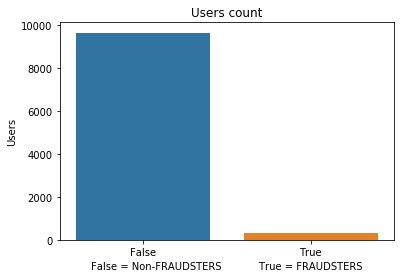

In [14]:
sns.barplot(x=user_df['IS_FRAUDSTER'].value_counts().index, y=user_df['IS_FRAUDSTER'].value_counts())
plt.title('Users count')
plt.ylabel('Users')
plt.xlabel('False = Non-FRAUDSTERS            True = FRAUDSTERS');

In [15]:
# Check that we have the same users as fraudsters in two datasets
set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values).issubset(set(fraud_df['USER_ID'].values)) and set(fraud_df['USER_ID'].values).issubset(set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values))

True

In [16]:
user_df[user_df['IS_FRAUDSTER']==True].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
8166,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,1,GB||JE||IM||GG,True,Undefined,2017-09-19 01:55:22.376000,LOCKED,GB,1988,NONE,0
8167,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,0
8168,27c76eda-e159-4df3-845a-e13f4e28a8b5,1,GB||JE||IM||GG,True,2018-05-25,2018-05-11 18:20:45.608000,LOCKED,GB,1997,PASSED,0
8169,a27088ef-9452-403d-9bbb-f7b10180cdda,1,IN,True,2018-05-25,2018-05-18 16:41:12.267000,LOCKED,BE,1989,PASSED,0
8170,fb23710b-609a-49bf-8a9a-be49c59ce6de,1,LT,True,2018-03-20,2018-03-29 13:37:29.736000,LOCKED,LT,1992,PASSED,0


In [17]:
# Check that only fraudsters are locked, so we aren't longer need to have STATE of user
user_df[user_df['IS_FRAUDSTER']==True]['STATE'].value_counts()

LOCKED    298
Name: STATE, dtype: int64

In [18]:
user_df.drop('STATE', axis=1, inplace=True)

In [19]:
# Create AGE variable as age on CREATED_DATE date of profile in system
user_df['AGE'] = user_df.apply(lambda x: datetime.strptime(x['CREATED_DATE'], '%Y-%m-%d %H:%M:%S.%f').year-x['BIRTH_YEAR'], axis=1)
# We don't need BIRTH_YEAR anymore - drop it
user_df.drop('BIRTH_YEAR', axis=1, inplace=True)

In [20]:
# create binary feature that Country is in Phone_country
user_df['HOMELAND_PHONE'] = user_df.apply(lambda x: 1 if x['COUNTRY'].upper() in x['PHONE_COUNTRY'].upper().split('||') else 0, axis=1)

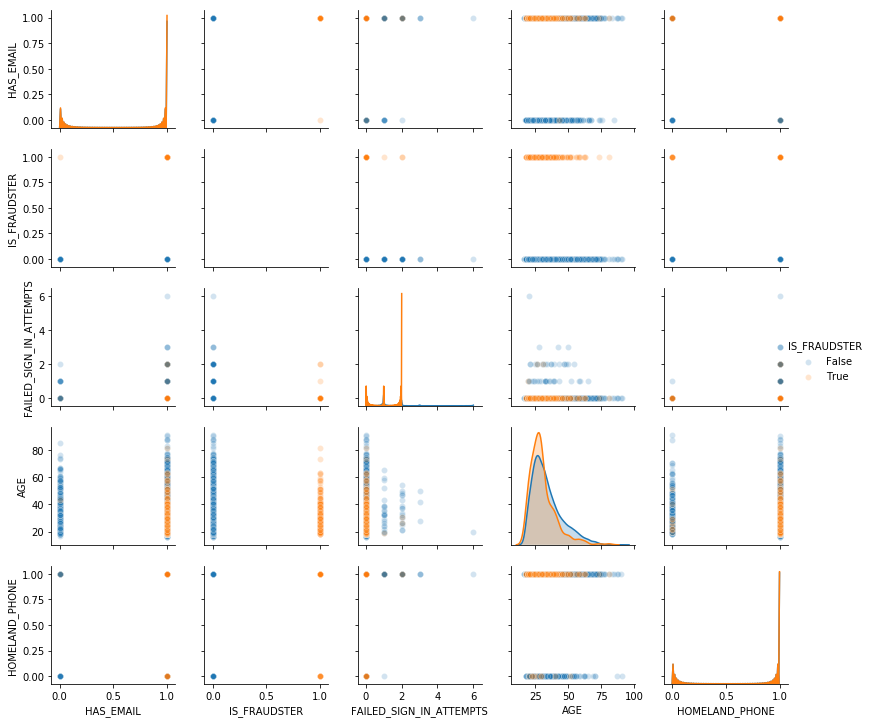

In [21]:
g=sns.pairplot(data=user_df,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)

There is one sign of fraudster in the user-dataset that fraudsters have two attempts to sign in maximum. They were probably worried about getting caught.

In [22]:
user_df[user_df['IS_FRAUDSTER']==True]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    295
2      2
1      1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

In [23]:
user_df[user_df['IS_FRAUDSTER']==False]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    9600
1      24
2      18
3       3
6       1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

So my preliminary observations for fraudsters are:

*  if country of merchant differ from country/phone_country of user
*  if currency of transaction differ from country of user
*  if period on platform is very small
*  if period between transactions is too small
*  if count of transactions is not common for this user
*  or MERCHANT_CATEGORY is not common for this user
*  or TYPE is not common for this user

*  new ideas: several bank transfers or single ATM-operation lead to LOCK
*  NAN merchant country lead to ALERT and LOCK
*  entry-method == man lead to ALERT

### Feature Engineering

#### Now look at the transactions.

In [24]:
trn_df.head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8
1,EUR,2593,COMPLETED,2017-12-20 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a
2,EUR,1077,COMPLETED,2017-12-20 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df
3,GBP,198,COMPLETED,2017-12-20 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53
4,EUR,990,COMPLETED,2017-12-20 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d


In [25]:
# look at the fraudster
trn_df[trn_df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].sort_values('CREATED_DATE', ascending=True)

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
132324,GBP,5000,COMPLETED,2018-04-06 18:43:33.955,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,961f9451-2d7d-4c62-8593-bf44d15d38b0
132344,GBP,4709,COMPLETED,2018-04-06 18:53:35.634,point_of_interest,LTU,manu,fb23710b-609a-49bf-8a9a-be49c59ce6de,CARD_PAYMENT,GAIA,953623dd-4d61-4f1a-b760-13fda4217b3b
142701,GBP,6500,COMPLETED,2018-04-09 14:53:30.372,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,eb2c9e9d-bffc-4347-9d86-28b6f0dea32d
142924,GBP,6000,COMPLETED,2018-04-09 17:23:08.928,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,P2P,INTERNAL,823e2403-eee1-4c74-beae-c53fdffdaae0


We will train model only on users with transactions:

In [26]:
trn_df = trn_df.rename({'ID': 'TRN_ID'}, axis=1)

In [27]:
df = trn_df.merge(user_df, left_on="USER_ID", right_on="ID").drop(['ID'],axis=1)
print(df.shape)
df.head()

(638742, 21)


,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE_y,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
1,GBP,175,COMPLETED,2017-12-19 12:40:55.325,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
2,GBP,220,COMPLETED,2017-12-19 12:45:05.706,department_store,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
3,GBP,210,COMPLETED,2017-12-21 07:42:25.629,NaN,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
4,GBP,485,COMPLETED,2017-12-21 08:36:56.132,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 21 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null object
MERCHANT_CATEGORY          208677 non-null object
MERCHANT_COUNTRY           447017 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null bool
TERMS_VERSION              638742 non-null object
CREATED_DATE_y             638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null 

In [29]:
# Replace NaN to 'Undefined' in MERCHANT_CATEGORY and MERCHANT_COUNTRY
df = df.fillna('Undefined')

In [30]:
df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: datetime.strptime(x+('000' if '.' in x else '.000000'), '%Y-%m-%d %H:%M:%S.%f'))
df['CREATED_DATE_y'] = df['CREATED_DATE_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [31]:
df['DAY_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%w')))
df['HOUR_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%H')))

In [32]:
# Create AGE variable as age on CREATED_DATE date of profile in system
df['PROFILE_AGE'] = df.apply(lambda x: (x['CREATED_DATE_x'] - x['CREATED_DATE_y']).days, axis=1)

In [33]:
# calc period of dataset to split on train/test
period = (df['CREATED_DATE_x'].max() - df['CREATED_DATE_x'].min()).days
print(f'Period of data is {period} days.')
#df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

Period of data is 940 days.


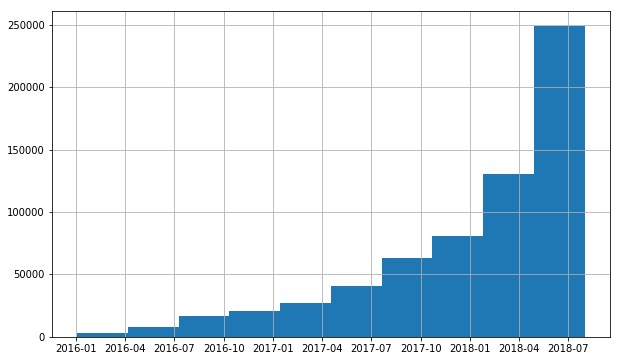

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
df['CREATED_DATE_x'].hist();

In [35]:
df['CREATED_DATE_x_date'] = df['CREATED_DATE_x'].apply(lambda x: x.date())

In [36]:
period_df = df.groupby(['CREATED_DATE_x_date']).agg('count')[['AMOUNT']].reset_index()
period_df.head()

,CREATED_DATE_x_date,AMOUNT
0,2016-01-03,1
1,2016-01-04,6
2,2016-01-05,2
3,2016-01-06,1
4,2016-01-07,3


In [37]:
period_df['cumsum'] = period_df['AMOUNT'].cumsum()/period_df['AMOUNT'].sum()
print(period_df[period_df['cumsum']>=(1-parameters.test_size)].head(1)['CREATED_DATE_x_date'].values[0])
period_df[period_df['cumsum']>=(1-parameters.test_size)].head()

2018-05-24


,CREATED_DATE_x_date,AMOUNT,cumsum
869,2018-05-24,2382,0.702650
870,2018-05-25,2818,0.707062
871,2018-05-26,2650,0.711210
872,2018-05-27,2288,0.714793
873,2018-05-28,2502,0.718710


In [38]:
delta_from_max_date = (df['CREATED_DATE_x_date'].max() - period_df[period_df['cumsum']>=(1-parameters.test_size)].head(1)['CREATED_DATE_x_date'].values[0]).days

In [39]:
print(f'We need to get only {delta_from_max_date} days from max_date back to history to get test_size = {parameters.test_size}')

We need to get only 68 days from max_date back to history to get test_size = 0.3


In [40]:
print(f"Date to split TRAIN and TEST is {df['CREATED_DATE_x_date'].max() - timedelta(days = delta_from_max_date)}")

Date to split TRAIN and TEST is 2018-05-24


In [41]:
parameters.days_from_max_to_split = delta_from_max_date

### Distribution of transactions by date (created_date_x) is left-skewed

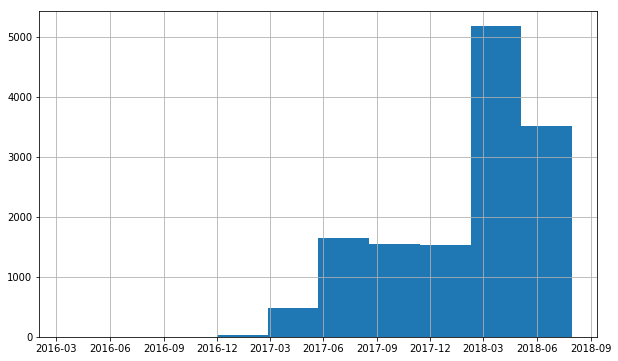

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
df[df['IS_FRAUDSTER']==1]['CREATED_DATE_x'].hist();

### Distribution of fraudster's transactions by date (created_date_x) is left-skewed

In [43]:
# No needs of CREATED_DATE_y anymore, drop them
df.drop(['CREATED_DATE_y'], axis=1, inplace=True)

In [44]:
# Transform boolean variable IS_FRAUDSTER to binary
df['IS_FRAUDSTER'] = df['IS_FRAUDSTER'].astype(int)

In [45]:
print(df.info())
print(df.describe().T)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 24 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null datetime64[ns]
MERCHANT_CATEGORY          638742 non-null object
MERCHANT_COUNTRY           638742 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null int64
TERMS_VERSION              638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null object
FAILED_SIGN_IN_ATTEMPTS    638742 

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE,CREATED_DATE_x_date
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,2018-05-25,GB,PASSED,0,55,1,3,12,83,2017-12-20
1,GBP,175,COMPLETED,2017-12-19 12:40:55.325,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,2018-05-25,GB,PASSED,0,55,1,2,12,82,2017-12-19
2,GBP,220,COMPLETED,2017-12-19 12:45:05.706,department_store,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,2018-05-25,GB,PASSED,0,55,1,2,12,82,2017-12-19
3,GBP,210,COMPLETED,2017-12-21 07:42:25.629,Undefined,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,2018-05-25,GB,PASSED,0,55,1,4,7,83,2017-12-21
4,GBP,485,COMPLETED,2017-12-21 08:36:56.132,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,2018-05-25,GB,PASSED,0,55,1,4,8,83,2017-12-21


### Let's transform countries to CODE3 format

In [46]:
df['COUNTRY'] = df['COUNTRY'].map({c[0]: c[1] for c in cntr_df[['CODE','CODE3']].values})

In [47]:
# We have numeric values of MERCHANT_COUNTRY!
df['MERCHANT_COUNTRY'].value_counts()

Undefined    191725
GBR          136448
USA           42723
FRA           27673
LTU           25040
              ...  
415               1
101               1
112               1
033               1
311               1
Name: MERCHANT_COUNTRY, Length: 304, dtype: int64

In [48]:
# Test single example of numeric country code
cntr_df[cntr_df['PHONECODE']==386]

,CODE,NAME,CODE3,NUMCODE,PHONECODE
182,SI,Slovenia,sVN,705,386


In [49]:
# Trying to replace country code to CODE3
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values)>0 else x) if x.isdigit() else x)
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE,CREATED_DATE_x_date
3463,EUR,10000,COMPLETED,2016-10-30 11:17:01.822,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,2018-03-20,gBR,PASSED,0,49,1,0,11,234,2016-10-30
3464,EUR,9000,COMPLETED,2016-10-28 10:30:21.334,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,2018-03-20,gBR,PASSED,0,49,1,5,10,232,2016-10-28
3480,EUR,6000,COMPLETED,2016-10-29 16:02:05.797,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,2018-03-20,gBR,PASSED,0,49,1,6,16,234,2016-10-29
9134,GBP,996,COMPLETED,2016-09-29 14:40:00.517,Undefined,000,manu,714661e3-b09b-42ef-a7b8-14a90bd455f5,CARD_PAYMENT,GAIA,...,2018-05-25,gBR,PASSED,0,42,1,4,14,75,2016-09-29
9157,GBP,1068,COMPLETED,2016-10-29 16:15:53.544,Undefined,000,manu,714661e3-b09b-42ef-a7b8-14a90bd455f5,CARD_PAYMENT,GAIA,...,2018-05-25,gBR,PASSED,0,42,1,6,16,105,2016-10-29


In [50]:
# Trying to replace country code to CODE3
# Add "C" to the missing countries
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values)>0 else 'C'+x) if x.isdigit() else x)
# Check that there is no any digits in country
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE,CREATED_DATE_x_date


In [51]:
# Fill NaN to Undefined and create binary variable HOMELAND to identify than transaction is made in country of user
df['COUNTRY'] = df['COUNTRY'].fillna('Undefined')
df['HOMELAND'] = df.apply(lambda x: 1 if x['COUNTRY'].upper() == x['MERCHANT_COUNTRY'].upper() else 0, axis=1)

#### Let's transform currency

In [52]:
df = pd.merge(df, cur_df, left_on="CURRENCY", right_on="CCY")
df['IS_CRYPTO'] = df['IS_CRYPTO'].astype(int)
df['AMOUNT'] = df['AMOUNT'] / (10**df['EXPONENT'])

In [53]:
df.columns

Index(['CURRENCY', 'AMOUNT', 'STATE', 'CREATED_DATE_x', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID', 'TYPE', 'SOURCE',
       'TRN_ID', 'HAS_EMAIL', 'PHONE_COUNTRY', 'IS_FRAUDSTER', 'TERMS_VERSION',
       'COUNTRY', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'HOMELAND_PHONE',
       'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'PROFILE_AGE',
       'CREATED_DATE_x_date', 'HOMELAND', 'CCY', 'EXPONENT', 'IS_CRYPTO'],
      dtype='object')

In [54]:
df = df[parameters.cols_to_select]

In [55]:
df.head()

,TRN_ID,USER_ID,CREATED_DATE_x,CURRENCY,AMOUNT,STATE,MERCHANT_CATEGORY,ENTRY_METHOD,TYPE,SOURCE,...,TERMS_VERSION,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,PROFILE_AGE,HOMELAND,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,IS_CRYPTO
0,b3332e6f-7865-4d6e-b6a5-370bc75568d8,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-20 12:46:20.294,GBP,1.75,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,3,12,0
1,bf0e3adf-a932-4e3d-be9c-45d702febf03,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:40:55.325,GBP,1.75,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,82,1,1,2,12,0
2,f5e63142-4577-482a-884e-b5b8b8526872,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:45:05.706,GBP,2.20,COMPLETED,department_store,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,82,1,1,2,12,0
3,839a3fbd-ea6c-4867-ae00-9048d636c261,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 07:42:25.629,GBP,2.10,COMPLETED,Undefined,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,4,7,0
4,12974850-86c9-44e8-ac27-af0fca755dbf,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 08:36:56.132,GBP,4.85,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,4,8,0


In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AMOUNT,638742.0,185.288777,17035.825815,0.0,4.64,13.9,50.0,9000000.0
HAS_EMAIL,638742.0,0.989255,0.103098,0.0,1.00,1.0,1.0,1.0
IS_FRAUDSTER,638742.0,0.021783,0.145976,0.0,0.00,0.0,0.0,1.0
FAILED_SIGN_IN_ATTEMPTS,638742.0,0.009552,0.141177,0.0,0.00,0.0,0.0,6.0
AGE,638742.0,31.985259,9.869479,16.0,25.00,29.0,37.0,91.0
PROFILE_AGE,638742.0,219.816344,197.082166,0.0,63.00,159.0,329.0,939.0
HOMELAND,638742.0,0.293715,0.455463,0.0,0.00,0.0,1.0,1.0
HOMELAND_PHONE,638742.0,0.926347,0.261205,0.0,1.00,1.0,1.0,1.0
DAY_OF_TRANSACTION,638742.0,3.124114,1.987050,0.0,1.00,3.0,5.0,6.0
HOUR_OF_TRANSACTION,638742.0,13.123067,5.540228,0.0,9.00,13.0,17.0,23.0


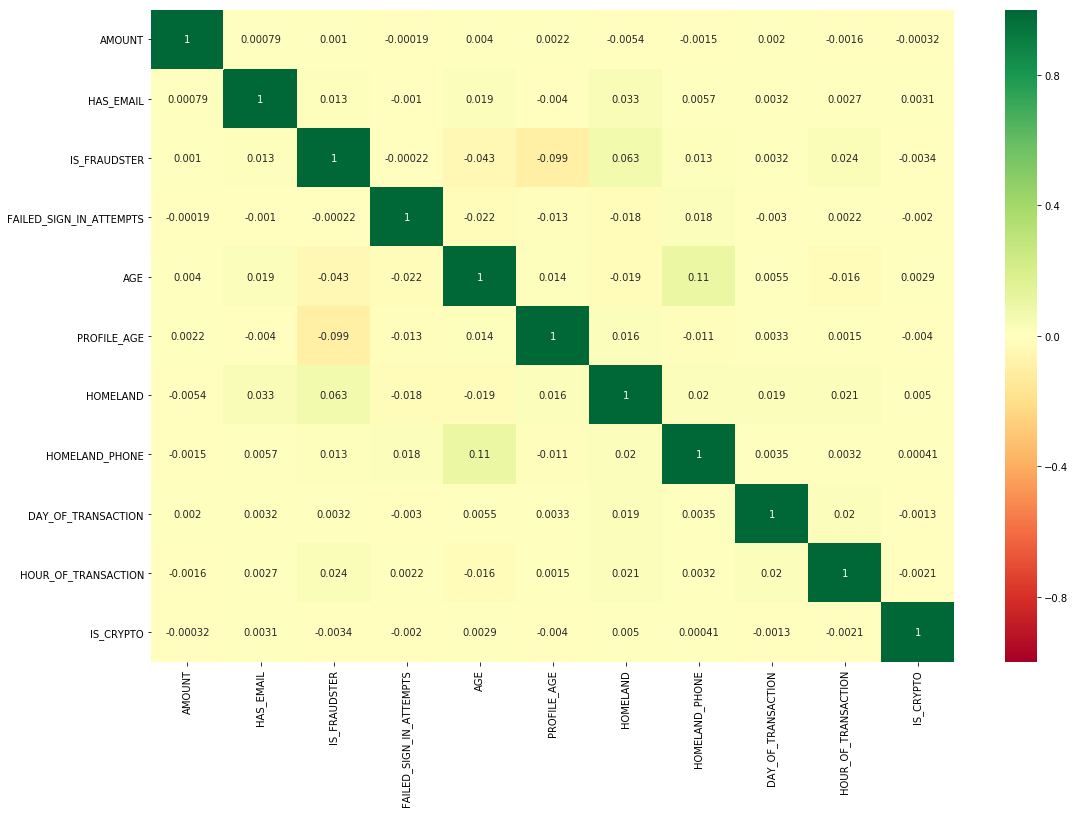

In [57]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(df.corr(),annot=True,cmap="RdYlGn",vmin=-1,vmax=1);

In [58]:
df_f = df[df['IS_FRAUDSTER']==1]
df_nof = df[df['IS_FRAUDSTER']==0]

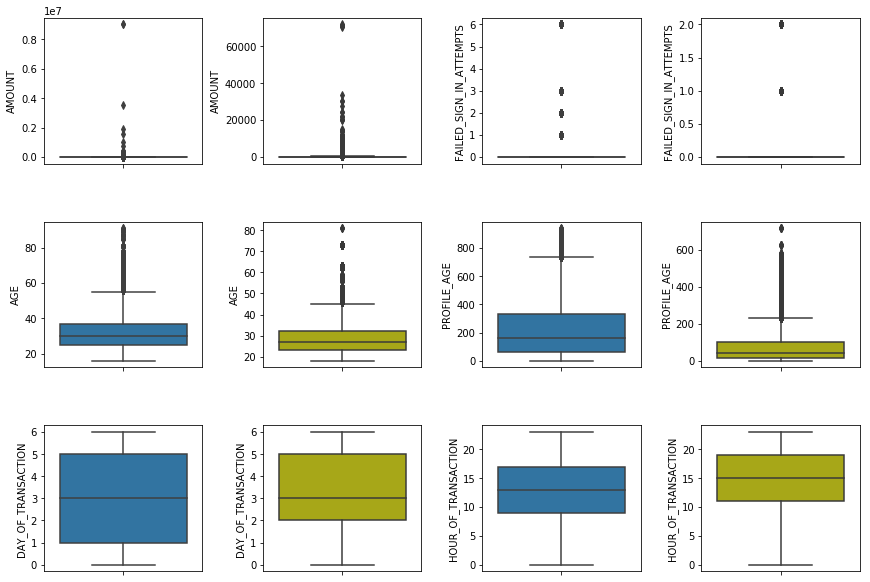

In [59]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 8))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df_nof[cols], ax=axs[index])
    index += 1
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index], color='y')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

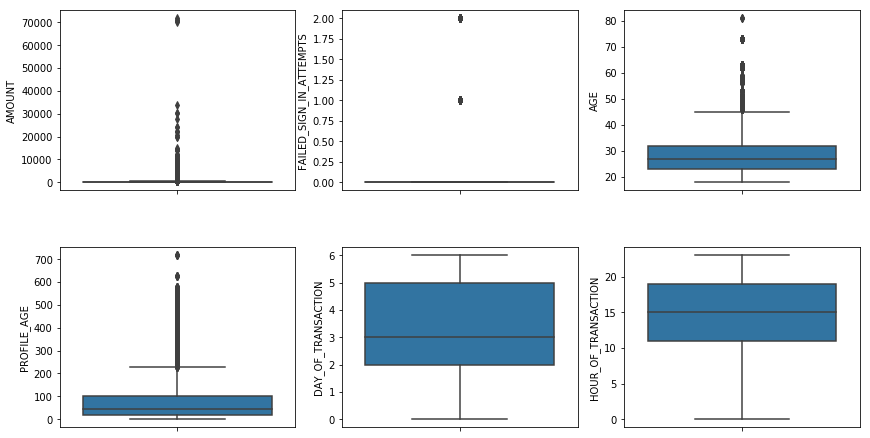

In [60]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df_f[cols].items():
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

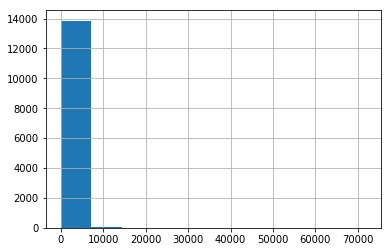

In [61]:
df[df['IS_FRAUDSTER']==1]['AMOUNT'].hist()

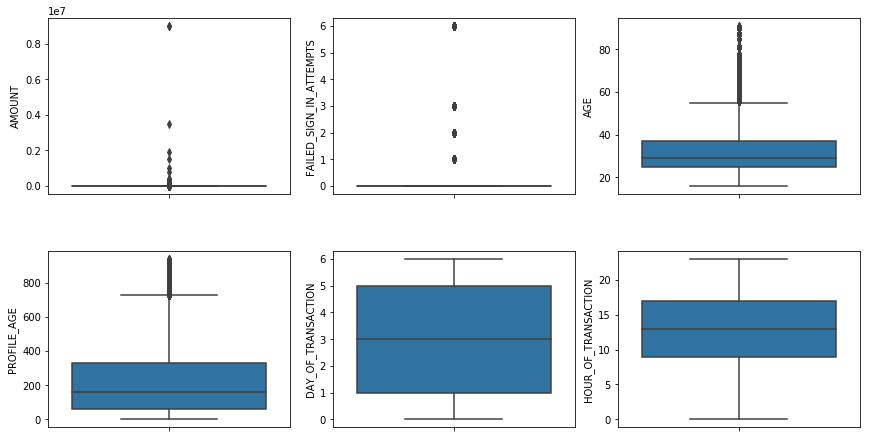

In [62]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [63]:
# store main dataset to the disk
df.to_csv(parameters.dataset_file_name, index=False)

Exclude from dataset users for final test and not train on them

In [64]:
df = pd.read_csv(parameters.dataset_file_name)

In [65]:
df = df[~df['USER_ID'].isin(test_users)]

#### Join the datasets to get full dataset

In [66]:
# Let's create dummy columns for categorical variables
df = pd.get_dummies(df, columns=parameters.cat_features)

### Ok, we have final dataset. Look at it.

In [67]:
print(df.shape)
print(list(df.columns))
df.head()

(638634, 200)
['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'IS_FRAUDSTER', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'M

,TRN_ID,USER_ID,CREATED_DATE_x,AMOUNT,HAS_EMAIL,IS_FRAUDSTER,FAILED_SIGN_IN_ATTEMPTS,AGE,PROFILE_AGE,HOMELAND,...,CURRENCY_PLN,CURRENCY_QAR,CURRENCY_RON,CURRENCY_SEK,CURRENCY_SGD,CURRENCY_THB,CURRENCY_TRY,CURRENCY_USD,CURRENCY_XRP,CURRENCY_ZAR
0,b3332e6f-7865-4d6e-b6a5-370bc75568d8,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-20 12:46:20.294,1.75,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0
1,bf0e3adf-a932-4e3d-be9c-45d702febf03,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:40:55.325,1.75,1,0,0,55,82,1,...,0,0,0,0,0,0,0,0,0,0
2,f5e63142-4577-482a-884e-b5b8b8526872,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:45:05.706,2.20,1,0,0,55,82,1,...,0,0,0,0,0,0,0,0,0,0
3,839a3fbd-ea6c-4867-ae00-9048d636c261,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 07:42:25.629,2.10,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0
4,12974850-86c9-44e8-ac27-af0fca755dbf,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 08:36:56.132,4.85,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# split dataset to features and predicted value
X, y = df, df[parameters.target_feature]
print(list(X.columns))

['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'IS_FRAUDSTER', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'MERCHANT_CATEGO

#### Classes are very unbalanced

In [69]:
df['IS_FRAUDSTER'].value_counts()

0    624720
1     13914
Name: IS_FRAUDSTER, dtype: int64

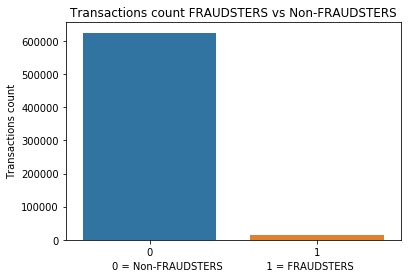

In [70]:
sns.barplot(x=df['IS_FRAUDSTER'].value_counts().index, y=df['IS_FRAUDSTER'].value_counts())
plt.title('Transactions count FRAUDSTERS vs Non-FRAUDSTERS')
plt.ylabel('Transactions count')
plt.xlabel('0 = Non-FRAUDSTERS              1 = FRAUDSTERS');

#### Let's split dataset by time to train and test datasets before changing class weights

In [71]:
def split_dataset(X, y, days=parameters.days_from_max_to_split, random_state=parameters.random_state):
    # Split dataset to train and test by min/max date and test_size
    X['CREATED_DATE_x'] = X['CREATED_DATE_x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
    max_date = max(X['CREATED_DATE_x'])
    date_test = max_date - timedelta(days = days)
    test_indexes = np.array([t > date_test for t in X['CREATED_DATE_x']])
    X.drop('CREATED_DATE_x', axis=1, inplace=True)
    X_train, y_train, X_test, y_test = X[~test_indexes], y[~test_indexes], X[test_indexes], y[test_indexes]
    return X_train, X_test, y_train, y_test
   
X_train, X_test_over, y_train, y_test_over = split_dataset(X, y, days=parameters.days_from_max_to_split, random_state=parameters.random_state)

In [72]:
print(X_train.shape, X_test_over.shape, len(y_train), len(y_test_over))

(448752, 199) (189882, 199) 448752 189882


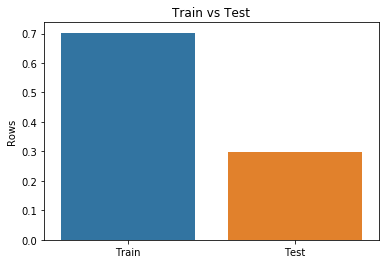

In [73]:
sns.barplot(x=['Train','Test'], y=[X_train.shape[0]/(X_train.shape[0]+X_test_over.shape[0]),X_test_over.shape[0]/(X_train.shape[0]+X_test_over.shape[0])])
plt.title("Train vs Test")
plt.ylabel('Rows');

In [74]:
len_train_1 = len(X_train[X_train['IS_FRAUDSTER']==1]['USER_ID'].unique())
len_train_0 = len(X_train[X_train['IS_FRAUDSTER']==0]['USER_ID'].unique())
print(f'There are {len_train_1} fraudsters and {len_train_0} non-fraudsters in TRAIN dataset and proportion is: {len_train_1/(len_train_1+len_train_0)}')

There are 267 fraudsters and 5873 non-fraudsters in TRAIN dataset and proportion is: 0.043485342019543974


In [75]:
len_test_1 = len(X_test_over[X_test_over['IS_FRAUDSTER']==1]['USER_ID'].unique())
len_test_0 = len(X_test_over[X_test_over['IS_FRAUDSTER']==0]['USER_ID'].unique())
print(f'There are {len_test_1} fraudsters and {len_test_0} non-fraudsters in TEST dataset and proportion is: {len_test_1/(len_test_1+len_test_0)}')

There are 95 fraudsters and 5153 non-fraudsters in TEST dataset and proportion is: 0.018102134146341462


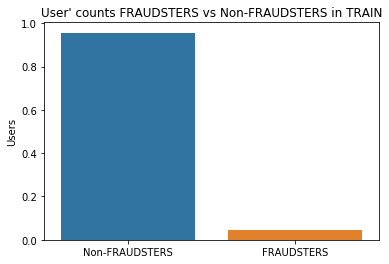

In [76]:
sns.barplot(x=['Non-FRAUDSTERS','FRAUDSTERS'], y=[len_train_0/(len_train_0+len_train_1),len_train_1/(len_train_0+len_train_1)])
plt.title("User' counts FRAUDSTERS vs Non-FRAUDSTERS in TRAIN")
plt.ylabel('Users');

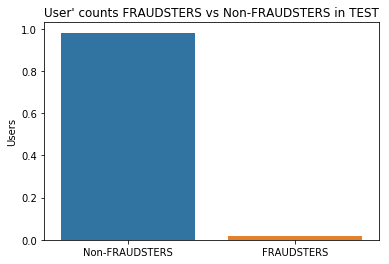

In [77]:
sns.barplot(x=['Non-FRAUDSTERS','FRAUDSTERS'], y=[len_test_0/(len_test_0+len_test_1),len_test_1/(len_test_0+len_test_1)])
plt.title("User' counts FRAUDSTERS vs Non-FRAUDSTERS in TEST")
plt.ylabel('Users');

In [78]:
len(X_train[X_train['IS_FRAUDSTER']==1]['TRN_ID'].unique()), len(X_train[X_train['IS_FRAUDSTER']==0]['TRN_ID'].unique())

(11408, 437344)

In [79]:
y_train.value_counts()

0    437344
1     11408
Name: IS_FRAUDSTER, dtype: int64

In [80]:
y_test_over.value_counts()

0    187376
1      2506
Name: IS_FRAUDSTER, dtype: int64

In [81]:
X_train, X_test_over = X_train.drop(parameters.id_features + [parameters.target_feature], axis=1), X_test_over.drop(parameters.id_features + [parameters.target_feature], axis=1)

In [82]:
X_train.columns

Index(['AMOUNT', 'HAS_EMAIL', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE',
       'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION',
       'HOUR_OF_TRANSACTION', 'IS_CRYPTO',
       ...
       'CURRENCY_PLN', 'CURRENCY_QAR', 'CURRENCY_RON', 'CURRENCY_SEK',
       'CURRENCY_SGD', 'CURRENCY_THB', 'CURRENCY_TRY', 'CURRENCY_USD',
       'CURRENCY_XRP', 'CURRENCY_ZAR'],
      dtype='object', length=196)

### Check performance on unbalanced classes

### Logistic Regression

In [83]:
lm = LogisticRegression().fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
roc_auc_train = roc_auc_score(y_train, y_train_predict)
print(f"ROC_AUC on train: {roc_auc_train}")

y_test_predict = lm.predict(X_test_over)

print(f"Test ROC_AUC    : {roc_auc_score(y_test_over, y_test_predict):.5f}")
print(f'Test Accuracy   : {accuracy_score(y_test_over, y_test_predict)}')
print(f'Test F1-score   : {f1_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Precision  : {precision_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Recall     : {recall_score(y_test_over, y_test_predict, average="macro")}')

ROC_AUC on train: 0.6969702203283243
Test ROC_AUC    : 0.55351
Test Accuracy   : 0.9875185641608999
Test F1-score   : 0.5896390513343268
Test Precision  : 0.8282579946845106
Test Recall     : 0.5535131404891261


### Balancing classes in train dataset

In [84]:
# Use sample from major class with number of observations in minor class
classes_count = y_train.value_counts()
min_class_count = classes_count.min()

X_train_over = []
y_train_over = []

for cls in zip(classes_count,classes_count.index):
    if cls[0] == min_class_count:
        X_minor_class = X_train[y_train==cls[1]]
        y_minor_class = y_train[y_train==cls[1]]
    else:
        X_major_class = X_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)
        y_major_class = y_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)

del X,y
X_train_over = pd.concat([X_minor_class,X_major_class])
y_train_over = pd.concat([y_minor_class,y_major_class])
df = pd.concat([X_train_over, y_train_over], axis=1)

In [85]:
df.to_csv(parameters.balanced_dataset_file_name, index=False)

In [86]:
df['IS_FRAUDSTER'].value_counts()

1    11408
0    11408
Name: IS_FRAUDSTER, dtype: int64

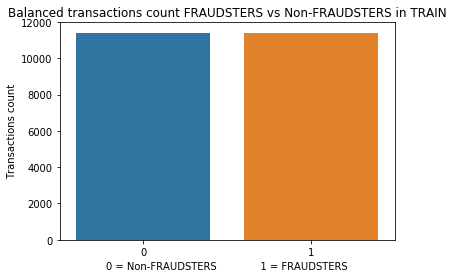

In [87]:
sns.barplot(x=df['IS_FRAUDSTER'].value_counts().index, y=df['IS_FRAUDSTER'].value_counts())
plt.title('Balanced transactions count FRAUDSTERS vs Non-FRAUDSTERS in TRAIN')
plt.ylabel('Transactions count')
plt.xlabel('0 = Non-FRAUDSTERS              1 = FRAUDSTERS');

### Do some statistical tests on balanced classes with obvious features

#### Let's test averages between groups of FRAUDSTERS and NON_FRAUDSTERS

In [88]:
# Apply scaler to normalize the dataset
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
#cols = ['AGE','PROFILE_AGE','AMOUNT','STANDART_PERIOD_HOUR']
cols = ['AGE','PROFILE_AGE','AMOUNT','DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION']
np_scaled = min_max_scaler.fit_transform(X_train_over[cols])
df_norm = pd.DataFrame(np_scaled, columns=cols)
df_norm = pd.concat([df_norm.reset_index(drop=True),y_train_over.reset_index(drop=True)], axis=1)
df_norm.head()

,AGE,PROFILE_AGE,AMOUNT,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,IS_FRAUDSTER
0,-0.459459,-0.944509,-0.998000,0.000000,0.304348,1
1,-0.459459,-0.944509,-0.999981,0.000000,0.391304,1
2,-0.459459,-0.946821,-0.993000,-0.333333,0.826087,1
3,-0.459459,-0.942197,-0.999800,0.333333,0.130435,1
4,-0.459459,-0.942197,-0.998000,0.333333,0.826087,1


In [89]:
# Split the dataset to fraudsters-dataset and non-fraudsters-dataset
df_fraud = df_norm[df_norm['IS_FRAUDSTER'] == 1]
df_nonfraud = df_norm[df_norm['IS_FRAUDSTER'] == 0]

In [90]:
def test_avg_diff(df1, df2, field_name, p_value_significance = .05):
    print(f'Check that average {field_name} differ between datasets...')
    p_val = sts.ttest_ind(df1[field_name], df2[field_name])[1]
    if p_val < p_value_significance:
        print(f'p-value ({p_val}) less than the level of significance ({p_value_significance}), \
which means that we can reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is different.')
    else:
        print(f'p-value ({p_val}) greater than the level of significance ({p_value_significance}), \
which means that we can''t reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is not different.')
    print('*'*80)

In [91]:
for c in cols:
    test_avg_diff(df_fraud, df_nonfraud, c)

Check that average AGE differ between datasets...
p-value (5.5210213965886706e-123) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AGE in datasets is different.
********************************************************************************
Check that average PROFILE_AGE differ between datasets...
p-value (0.0) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average PROFILE_AGE in datasets is different.
********************************************************************************
Check that average AMOUNT differ between datasets...
p-value (2.7314103968439252e-05) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AMOUNT in datasets is different.
***************************************************

In [ ]:
g=sns.pairplot(data=df_norm,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)
del df_norm

### Model Selection/Validation
#### Let's create an ML model which identifies fraudsters.

We could split task to two:
*  Solve binary classification: fraudster or not
*  Use the probabilities of binary classifier or solve multiclass classification problem with classes: 'PASS', 'LOCK_USER', 'ALERT_AGENT', 'LOCK_USER+ALERT_AGENT'

In [ ]:
y_train_over.value_counts()

In [ ]:
X_train_over.shape

### Baseline model - Logistic Regression

In [ ]:
lm = LogisticRegression().fit(X_train_over,y_train_over)
y_train_predict = lm.predict(X_train_over)
roc_auc_train = roc_auc_score(y_train_over, y_train_predict)
print(f"ROC_AUC on train: {roc_auc_train}")

y_test_predict = lm.predict(X_test_over)

print(f"Test ROC_AUC    : {roc_auc_score(y_test_over, y_test_predict):.5f}")
print(f'Test Accuracy   : {accuracy_score(y_test_over, y_test_predict)}')
print(f'Test F1-score   : {f1_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Precision  : {precision_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Recall     : {recall_score(y_test_over, y_test_predict, average="macro")}')

### With baseline model we can see improvements if we have balanced classes!

### Random Forest

In [ ]:
# train simple randomforest with KFold
rf = RandomForestClassifier(n_jobs=-1,random_state=parameters.random_state)
print(rf)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_over,y_train_over):
    X_train_fold,y_train_fold = X_train_over.iloc[trn_idx],y_train_over.iloc[trn_idx]
    X_test_fold,y_test_fold = X_train_over.iloc[tst_idx],y_train_over.iloc[tst_idx]
    rf.fit(X_train_fold,y_train_fold)
    score_on_train += rf.score(X_test_fold,y_test_fold)

rf.fit(X_train_over,y_train_over)
print(f'Score on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
print(f'Score on test : {rf.score(X_test_over,y_test_over)}')

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

In [97]:
%%time
params = {'n_estimators':[10,20,50,100],
          'max_depth':[5,10,15,20,25,30],
          'min_samples_leaf':[1,5,10],
          'min_samples_split' : [2,10,100],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]
         }

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)
rf = rf_grid.best_estimator_

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.88081
Test Accuracy  : 0.94271
Test F1-score  : 0.62185
Test Precision : 0.58083
Test Recall    : 0.88081
CPU times: user 8.91 s, sys: 1.42 s, total: 10.3 s
Wall time: 2min 35s


In [98]:
# store list of features to the model parameter
rf.feature_names = list(X_train_over.columns.values)
# save model to artifact
#joblib.dump(rf, parameters.model_pkl)
pickle.dump(rf, open(parameters.model_pkl, 'wb'))
#rf = joblib.load(model_pkl)

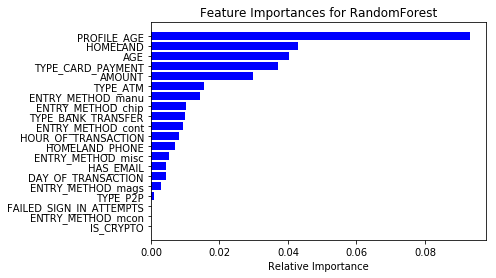

In [99]:
# Let's look at features importance
features = X_train_over.columns
importances = rf.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for RandomForest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
del rf

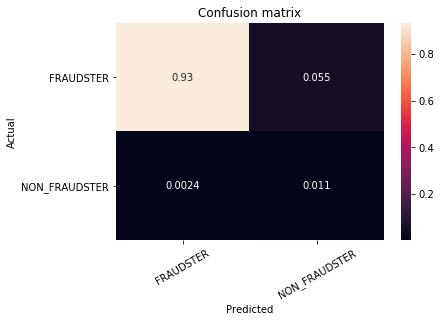

In [100]:
df_conf = pd.DataFrame({'y_Actual': y_test_over, 'y_Predicted': rf_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_conf['y_Actual'], df_conf['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_gr = confusion_matrix/sum(sum(confusion_matrix.values))
class_names = ['FRAUDSTER','NON_FRAUDSTER']
ax=sns.heatmap(confusion_matrix_gr, annot=True);
ax.set_title('Confusion matrix')
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=30);

In [101]:
confusion_matrix

Predicted,0,1
Actual,,
0,176955,10421
1,458,2048


Because of min_samples_leaf=1 we might think that classifier has been overfitting on train dataset. But TEST accuracy and F1-score are very good for RandomForest only with 10 trees.

Let's do the grid search of parameters for randomforest

In [102]:
%%time
params = {'n_estimators':[10,20],
          'max_depth':[5,10,20],
          'min_samples_leaf':[1,5,10],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 7}
CPU times: user 1.2 s, sys: 116 ms, total: 1.32 s
Wall time: 5.2 s


In [103]:
rf_pred = rf_grid.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.88081
Test Accuracy  : 0.94271
Test F1-score  : 0.62185
Test Precision : 0.58083
Test Recall    : 0.88081


We have no improvements on TEST after gridsearch on RF.

### XGBoost

In [104]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)

rf_pred = rf_grid.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

{'max_depth': 7, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.88361
Test Accuracy  : 0.96143
Test F1-score  : 0.66749
Test Precision : 0.61249
Test Recall    : 0.88361
CPU times: user 23.7 s, sys: 696 ms, total: 24.4 s
Wall time: 10min 47s


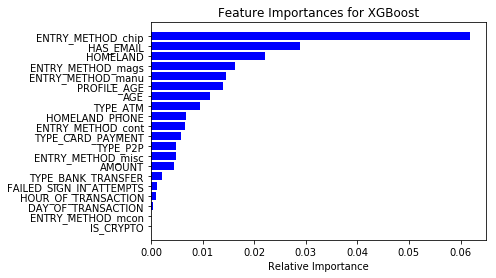

In [105]:
# Let's look at features importance
features = X_train_over.columns
rf = rf_grid.best_estimator_
importances = rf.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for XGBoost')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
del rf

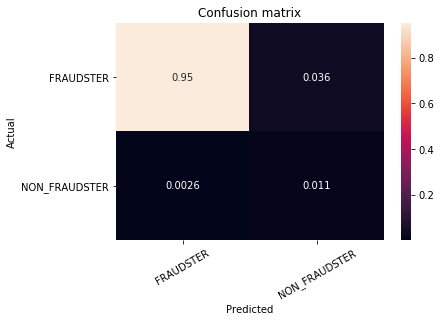

In [106]:
df_conf = pd.DataFrame({'y_Actual': y_test_over, 'y_Predicted': rf_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_conf['y_Actual'], df_conf['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_gr = confusion_matrix/sum(sum(confusion_matrix.values))
class_names = ['FRAUDSTER','NON_FRAUDSTER']
ax=sns.heatmap(confusion_matrix_gr, annot=True);
ax.set_title('Confusion matrix')
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=30);

In [107]:
confusion_matrix

Predicted,0,1
Actual,,
0,180545,6831
1,492,2014


## Let's try PCA to minimize number of features for model.

In [108]:
print(f'Current shape of the dataset: {X_train_over.shape}')

Current shape of the dataset: (22816, 196)


### Check RF with PCA

In [109]:
l_result = []
for n in range(1,df.shape[1]//4):
    pca = PCA(n_components=n, random_state=parameters.random_state)
    pc = pca.fit_transform(X_train_over)
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)
    
    rf_pca = RandomForestClassifier(n_jobs=-1, random_state=parameters.random_state)
    score_on_train = 0
    for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_pca,y_train_pca):
        X_train_fold,y_train_fold = X_train_pca.iloc[trn_idx],y_train_pca.iloc[trn_idx]
        X_test_fold,y_test_fold = X_train_pca.iloc[tst_idx],y_train_pca.iloc[tst_idx]
        rf_pca.fit(X_train_fold, y_train_fold)
        score_on_train += rf_pca.score(X_test_fold, y_test_fold)

    rf_pca.fit(X_train_pca,y_train_pca)
    print(f'Components={n}; Accuracy on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
    print(f'Components={n}; Accuracy on test : {rf_pca.score(X_test_pca,y_test_pca)}')
    y_test_predict_proba = rf_pca.predict_proba(X_test_pca)[:, 1]
    y_test_predict = rf_pca.predict(X_test_pca)
    l_result.append((n,
                     roc_auc_score(y_test_pca, y_test_predict_proba),
                     accuracy_score(y_test_pca, y_test_predict),
                     f1_score(y_test_pca, y_test_predict, average="macro")
                    ))

Components=1; Accuracy on train by 3 folds : 0.6312693842065057
Components=1; Accuracy on test : 0.6362308254200146
Components=2; Accuracy on train by 3 folds : 0.6982654785833878
Components=2; Accuracy on test : 0.7095690284879475
Components=3; Accuracy on train by 3 folds : 0.8053967164687367
Components=3; Accuracy on test : 0.8154857560262966
Components=4; Accuracy on train by 3 folds : 0.8107194706084137
Components=4; Accuracy on test : 0.8179693206720233
Components=5; Accuracy on train by 3 folds : 0.8066493782868847
Components=5; Accuracy on test : 0.8189919649379109
Components=6; Accuracy on train by 3 folds : 0.8360782153100068
Components=6; Accuracy on test : 0.8582907231555881
Components=7; Accuracy on train by 3 folds : 0.9128420137269151
Components=7; Accuracy on test : 0.9161431701972242
Components=8; Accuracy on train by 3 folds : 0.9172250362613251
Components=8; Accuracy on test : 0.9215485756026297
Components=9; Accuracy on train by 3 folds : 0.9244882988212653
Componen

In [110]:
# Sort by ROC_AUC and F1-score on Test
#l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
l_result.sort(key=lambda x:x[3],reverse=True)
l_result

[(10, 0.9817445775842006, 0.9425858290723156, 0.942583868391017),
 (30, 0.9798153942978303, 0.9415631848064281, 0.941561826563014),
 (44, 0.9794708774640146, 0.9414170927684441, 0.9414146720330869),
 (40, 0.9782906586635973, 0.9412710007304602, 0.9412697961439618),
 (19, 0.9815155257529214, 0.9411249086924762, 0.9411224758836261),
 (11, 0.9805932143629755, 0.9409788166544923, 0.9409755400390819),
 (17, 0.9815602604378227, 0.9405405405405406, 0.9405388958239764),
 (37, 0.9806408516801034, 0.9402483564645727, 0.9402463159590992),
 (27, 0.9810420125281022, 0.9398100803506209, 0.9398081263703644),
 (31, 0.9796008983134512, 0.939517896274653, 0.9395169552212507),
 (35, 0.9781364776694527, 0.9393718042366691, 0.9393692989868605),
 (42, 0.9788323410599696, 0.9392257121986852, 0.9392237392477465),
 (18, 0.9798917591368459, 0.9392257121986852, 0.9392233137688206),
 (38, 0.980530124797819, 0.9389335281227174, 0.9389317438055167),
 (24, 0.9801873580804927, 0.9389335281227174, 0.9389261959853485),

In [111]:
print(f'Best n_components by PCA: {l_result[0][0]}')

Best n_components by PCA: 10


In [112]:
parameters.best_pca_components_number = l_result[0][0]
parameters.best_pca = PCA(n_components=parameters.best_pca_components_number, random_state=parameters.random_state)
parameters.best_pca.fit(X_train_over);

In [113]:
ds_pc = parameters.best_pca.transform(X_train_over)
df_pc = pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)])
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [114]:
%%time
params = {'n_estimators':[10,20],
          'max_depth':[5,10,20],
          'min_samples_leaf':[1,5,10],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_pca,y_train_pca)
print(rf_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 7}
CPU times: user 2.12 s, sys: 257 ms, total: 2.37 s
Wall time: 5.75 s


In [115]:
rf_pca = rf_grid.best_estimator_
rf_pca.fit(X_train_pca,y_train_pca)
rf_pred = rf_pca.predict(X_test_pca)
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]

print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, y_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.98374
Test Accuracy  : 0.94463
Test F1-score  : 0.94463
Test Precision : 0.94481
Test Recall    : 0.94463


### Check XGBoost with PCA

In [116]:
l_result = []
for n in range(1,df.shape[1]//4):
    pca = PCA(n_components=n, random_state=parameters.random_state)
    pc = pca.fit_transform(X_train_over)
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)
    
    rf_pca = XGBClassifier(n_jobs=-1, random_state=parameters.random_state)
    score_on_train = 0
    for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_pca,y_train_pca):
        X_train_fold,y_train_fold = X_train_pca.iloc[trn_idx],y_train_pca.iloc[trn_idx]
        X_test_fold,y_test_fold = X_train_pca.iloc[tst_idx],y_train_pca.iloc[tst_idx]
        rf_pca.fit(X_train_fold, y_train_fold)
        score_on_train += rf_pca.score(X_test_fold, y_test_fold)

    rf_pca.fit(X_train_pca,y_train_pca)
    print(f'Components={n}; Accuracy on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
    print(f'Components={n}; Accuracy on test : {rf_pca.score(X_test_pca,y_test_pca)}')
    y_test_predict_proba = rf_pca.predict_proba(X_test_pca)[:, 1]
    y_test_predict = rf_pca.predict(X_test_pca)
    l_result.append((n,
                     roc_auc_score(y_test_pca, y_test_predict_proba),
                     accuracy_score(y_test_pca, y_test_predict),
                     f1_score(y_test_pca, y_test_predict, average="macro")))

Components=1; Accuracy on train by 3 folds : 0.6543107163066081
Components=1; Accuracy on test : 0.6420745069393718
Components=2; Accuracy on train by 3 folds : 0.7105378122968248
Components=2; Accuracy on test : 0.706208911614317
Components=3; Accuracy on train by 3 folds : 0.7812912569756797
Components=3; Accuracy on test : 0.775018261504748
Components=4; Accuracy on train by 3 folds : 0.7821678732446444
Components=4; Accuracy on test : 0.7739956172388605
Components=5; Accuracy on train by 3 folds : 0.7790369479484082
Components=5; Accuracy on test : 0.7739956172388605
Components=6; Accuracy on train by 3 folds : 0.7908082404587513
Components=6; Accuracy on test : 0.7899196493791089
Components=7; Accuracy on train by 3 folds : 0.8860436724252412
Components=7; Accuracy on test : 0.8772826880934989
Components=8; Accuracy on train by 3 folds : 0.8921795981592623
Components=8; Accuracy on test : 0.8819576333089847
Components=9; Accuracy on train by 3 folds : 0.8918040113313083
Components

In [117]:
# Sort by ROC_AUC and F1-score on Test
#l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
# Sort by F1-score
l_result.sort(key=lambda x:x[3],reverse=True)
l_result

[(41, 0.9764652871650896, 0.9221329437545653, 0.9220882194165694),
 (44, 0.9770412889189625, 0.9219868517165815, 0.9219358269583157),
 (48, 0.9765078021900532, 0.9216946676406136, 0.9216491410901448),
 (46, 0.9767587091345665, 0.9212563915266618, 0.921213344245509),
 (42, 0.9762328204723674, 0.9212563915266618, 0.9212042983360609),
 (38, 0.9761018605360343, 0.920964207450694, 0.9209045423556466),
 (45, 0.977015464029301, 0.9206720233747261, 0.9206253411932469),
 (47, 0.9767164502242113, 0.9206720233747261, 0.9206195435927294),
 (35, 0.9752408885947556, 0.9202337472607743, 0.9201815758787273),
 (39, 0.975627194795478, 0.9202337472607743, 0.9201702825499988),
 (43, 0.9766985648874043, 0.9193571950328707, 0.9193168844928283),
 (29, 0.9753236136132085, 0.9193571950328707, 0.9193056498090215),
 (37, 0.9760318131906878, 0.9193571950328707, 0.9193032370455558),
 (34, 0.9745009308058579, 0.9193571950328707, 0.9192930329076912),
 (36, 0.9756995044865303, 0.9190650109569029, 0.9190032599215896),

In [118]:
print(f'Best n_components by PCA: {l_result[0][0]}')

Best n_components by PCA: 41


In [119]:
parameters.best_pca_components_number = l_result[0][0]
parameters.best_pca = PCA(n_components=parameters.best_pca_components_number, random_state=parameters.random_state)
parameters.best_pca.fit(X_train_over);

We can see improvement on TEST with PCA.

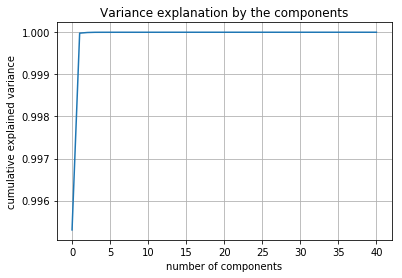

In [120]:
plt.plot(np.cumsum(parameters.best_pca.explained_variance_ratio_))
plt.title('Variance explanation by the components')
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It looks like we could use even 4 component for the good quality.  
Check it:

In [121]:
test_pca = PCA(n_components=4, random_state=parameters.random_state)
test_ds_pc = test_pca.fit_transform(X_train_over)
test_df_pc = pd.DataFrame(data = test_ds_pc, columns = ['pc'+str(i) for i in range(4)])
X_comp_train_pca, X_comp_test_pca, y_comp_train_pca, y_comp_test_pca = train_test_split(test_df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [122]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_comp_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_comp_grid.fit(X_comp_train_pca,y_comp_train_pca)
print(rf_comp_grid.best_params_)

rf_comp_pred = rf_comp_grid.predict(X_comp_test_pca)
rf_comp_pred_proba = rf_comp_grid.predict_proba(X_comp_test_pca)[::,1]
print (f"Test ROC_AUC   : {roc_auc_score(y_comp_test_pca, rf_comp_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_comp_test_pca,rf_comp_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")

{'max_depth': 11, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.91842
Test Accuracy  : 0.83974
Test F1-score  : 0.83947
Test Precision : 0.84201
Test Recall    : 0.83973
CPU times: user 34.7 s, sys: 162 ms, total: 34.9 s
Wall time: 59.2 s


No so good.  
Let's return to the best component number:

In [123]:
ds_pc = parameters.best_pca.transform(X_train_over)
df_pc = pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)])
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [124]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_grid.fit(X_train_pca,y_train_pca)
print(rf_grid.best_params_)

{'max_depth': 9, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 7}
CPU times: user 2min 12s, sys: 418 ms, total: 2min 12s
Wall time: 6min 29s


In [125]:
rf_pca = rf_grid.best_estimator_
rf_pca.fit(X_train_pca,y_train_pca)
rf_pred = rf_pca.predict(X_test_pca)
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]

print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, y_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.99180
Test Accuracy  : 0.95690
Test F1-score  : 0.95689
Test Precision : 0.95746
Test Recall    : 0.95690


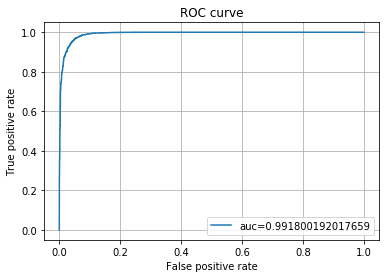

In [126]:
fpr, tpr, _ = roc_curve(y_test_pca,  y_pred_proba)
auc = roc_auc_score(y_test_pca, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.legend(loc=4)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

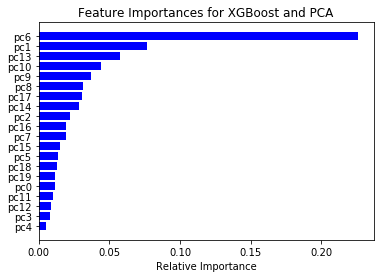

In [127]:
# Let's look at features importance
features = list(X_train_pca.columns.values)
importances = rf_pca.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for XGBoost and PCA')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

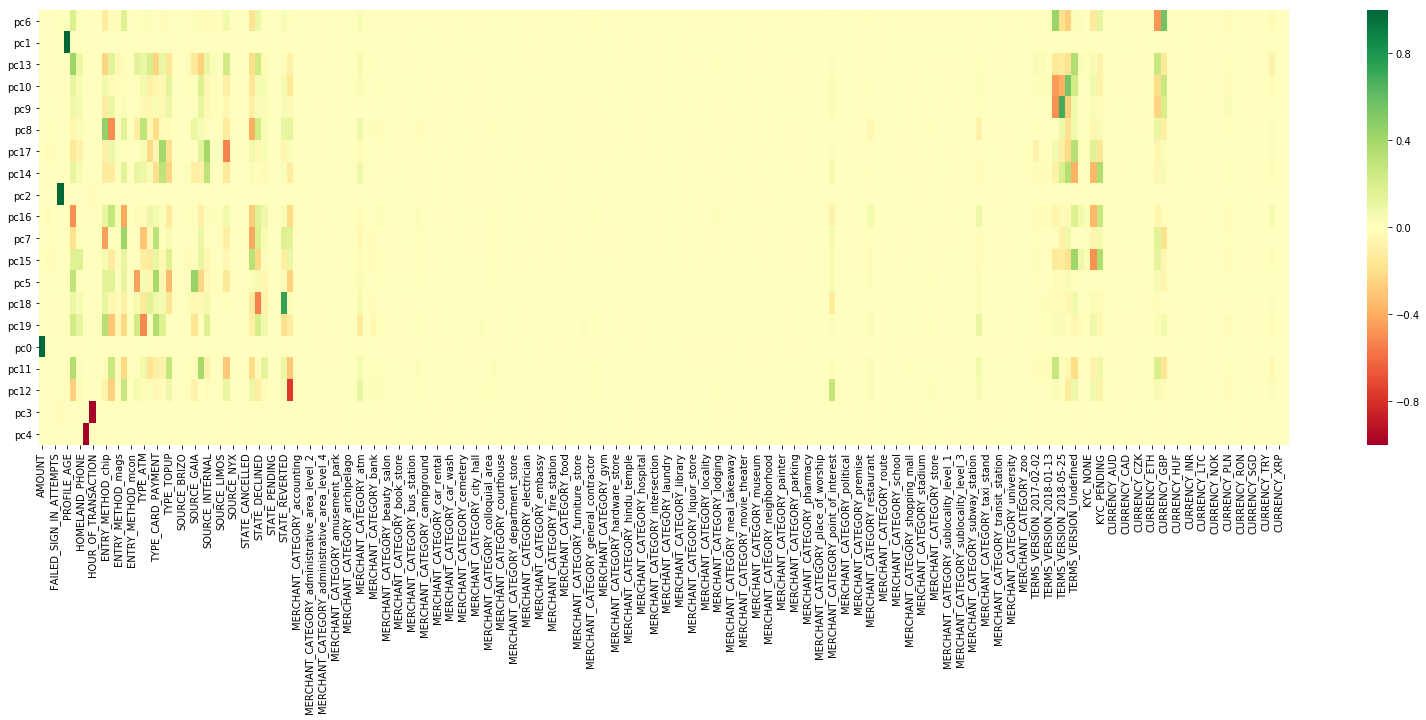

In [128]:
fig, ax = plt.subplots(figsize=(28,8))
sns.heatmap(pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc[[features[i] for i in indices[::-1]]],cmap="RdYlGn",vmin=-1,vmax=1);

Check the most important feature PC6

In [129]:
pcs = pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc['pc6']

Look at the real features inside the PC6

In [130]:
pcs.sort_values()

CURRENCY_EUR               -0.470389
TERMS_VERSION_2018-09-20   -0.259930
TERMS_VERSION_2018-05-25   -0.191110
STATE_COMPLETED            -0.166100
KYC_PASSED                 -0.135404
                              ...   
KYC_PENDING                 0.119044
ENTRY_METHOD_manu           0.166564
HOMELAND                    0.193090
TERMS_VERSION_2018-03-20    0.437195
CURRENCY_GBP                0.559896
Name: pc6, Length: 196, dtype: float64

We see that there others most absolut weighted features inside the PC6 than in FeatureImportance of RF with real features, but there are some common.

Ok, store list of features to the model parameter and save model to artifact

In [131]:
pickle.dump(rf_pca, open(parameters.model_pkl, 'wb'))

## Operationalization
- How to utilize this model to catch fraudsters? If a fraudster is identified, what should be the resulting action: LOCK_USER, ALERT_AGENT, or BOTH?  
- Let's make a patrol-function which implements this logic. The function should accept a user_id and yield the suggested action(s) (e.g. patrol(user_id) = [‘LOCK_USER’, ‘ALERT_AGENT’])

Now we can:  
* check single transaction to be fraud transaction
* check the whole user for all his transactions

In binary classification we could use predict-proba to predict percent of probability that this is Fraudster. I think it'd be usefull to operate with three level of attention:
*  If percent is more than first level (50% for example) we need ALERT.
*  If percent is more than second level (75% for example) we need LOCK and ALERT.
*  If percent is more than max level (90% for example) we need LOCK.

In [132]:
# load our pretrained model
#rf = joblib.load(parameters.model_pkl)
rf = pickle.load(open(parameters.model_pkl,'rb'))
print('Pretrained model: ', rf)
#print('\nFeatures of this model: ', rf.feature_names)
print('\nFeatures of this model: ', list(X_train_pca.columns.values))

Pretrained model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan, n_estimators=200,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Features of this model:  ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38', 'pc39', 'pc40']


In [133]:
# Let's look at the fraudsters
user_df = pd.read_csv(parameters.user_dataset)
user_df[user_df['IS_FRAUDSTER']==True].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
8166,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,1,GB||JE||IM||GG,True,NaN,2017-09-19 01:55:22.376000,LOCKED,GB,1988,NONE,0
8167,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,0
8168,27c76eda-e159-4df3-845a-e13f4e28a8b5,1,GB||JE||IM||GG,True,2018-05-25,2018-05-11 18:20:45.608000,LOCKED,GB,1997,PASSED,0
8169,a27088ef-9452-403d-9bbb-f7b10180cdda,1,IN,True,2018-05-25,2018-05-18 16:41:12.267000,LOCKED,BE,1989,PASSED,0
8170,fb23710b-609a-49bf-8a9a-be49c59ce6de,1,LT,True,2018-03-20,2018-03-29 13:37:29.736000,LOCKED,LT,1992,PASSED,0


In [134]:
# Test prediction from full datasets from files
# load data from files
df = pd.read_csv(parameters.dataset_file_name)[parameters.cols_to_select]

In [135]:
# Let's create dummy columns for categorical variables
df = pd.get_dummies(df, columns=parameters.cat_features)

In [136]:
ds_pc = parameters.best_pca.transform(df.drop(parameters.id_features + [parameters.target_feature] + ['CREATED_DATE_x'], axis=1))
df = pd.concat([pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)]), df[parameters.id_features + [parameters.target_feature]]], axis=1)

In [137]:
df.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc34,pc35,pc36,pc37,pc38,pc39,pc40,USER_ID,TRN_ID,IS_FRAUDSTER
0,-216.929639,-68.549575,24.763310,1.292724,0.112950,1.247565,0.274153,-0.310793,-0.866494,0.962703,...,-0.049566,-0.010845,-0.424098,-0.212813,0.694716,-0.270411,0.006191,8f99c254-7cf2-4e35-b7e4-53804d42445d,b3332e6f-7865-4d6e-b6a5-370bc75568d8,0
1,-216.928474,-69.549775,24.768030,1.288133,1.112665,1.247515,0.272426,-0.317097,-0.868909,0.963644,...,-0.048805,-0.011546,-0.422580,-0.212674,0.695812,-0.270049,0.006418,8f99c254-7cf2-4e35-b7e4-53804d42445d,bf0e3adf-a932-4e3d-be9c-45d702febf03,0
2,-216.478474,-69.549269,24.768076,1.287606,1.112668,1.240087,0.272905,-0.311351,-0.849784,0.959907,...,-0.023822,0.012617,-0.068847,0.015942,-0.046384,0.087151,-0.017812,8f99c254-7cf2-4e35-b7e4-53804d42445d,f5e63142-4577-482a-884e-b5b8b8526872,0
3,-216.579670,-68.544937,24.854563,6.298272,-0.859248,0.965408,0.281030,-0.145858,-0.725661,0.906428,...,-0.003130,-0.012158,0.010409,-0.012874,-0.020747,0.020346,0.004649,8f99c254-7cf2-4e35-b7e4-53804d42445d,839a3fbd-ea6c-4867-ae00-9048d636c261,0
4,-213.829671,-68.542362,24.834123,5.297288,-0.865640,1.233410,0.290514,-0.314683,-0.872956,0.957055,...,-0.050067,-0.013495,-0.423451,-0.213486,0.690868,-0.272379,0.006979,8f99c254-7cf2-4e35-b7e4-53804d42445d,12974850-86c9-44e8-ac27-af0fca755dbf,0


### 1. We can check all transactions of the same fraudster

In [138]:
X = df[df['USER_ID']=='848fc1b1-096c-40f7-b04a-1399c469e421'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[1]

In [139]:
rf.classes_, rf.predict_proba(X)

(array([0, 1]), array([[0.02365178, 0.9763482 ],
        [0.11725473, 0.88274527],
        [0.7330383 , 0.26696166],
        [0.38373256, 0.61626744],
        [0.18634808, 0.8136519 ],
        [0.15138459, 0.8486154 ]], dtype=float32))

So we have to use second argument of predict_proba to get the probability of being fraudster.

### 2. We can check the single transaction of fraudster

In [140]:
X = df[df['TRN_ID']=='961f9451-2d7d-4c62-8593-bf44d15d38b0'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1][0]
print(f"Probability of class IS_FRAUDSTER=1 = {y_pred}")

Probability of class IS_FRAUDSTER=1 = 0.9997201561927795


And model predicted this transaction is by fraudster!

In [141]:
# Now check another fraudster's transactions
X = df[df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99972016 0.99824774 0.99954516 0.9246435 ]


And model predicted that this is fraudster!

In [142]:
# look at not fraudsters
user_df[user_df['IS_FRAUDSTER']==False].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0


In [143]:
# Now check not fraudster's transactions
X = df[df['USER_ID']=='1872820f-e3ac-4c02-bdc7-727897b60043'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[3.7801836e-03 7.4787349e-01 9.6288103e-01 5.1727824e-05 2.4277126e-05
 2.8656403e-05]


And model classifying this user as not a fraudster!

### Let's build production-mode function

In [144]:
def get_user_data(user_id, asserting=False):
    # Load data from dataframe df
    result = df[df['USER_ID']==user_id].drop(parameters.id_features + [parameters.target_feature],axis=1)
    if asserting:
        assert len(result) > 0, f"We don't have data for user_id={user_id}!"
    return result

In [145]:
# Test fraudster user
X = get_user_data(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de', asserting=True)
X.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40
256910,-168.593282,-143.631513,-3.982061,-4.133395,-1.923923,-1.407655,0.386215,-0.283565,-0.335758,-0.444748,...,-0.005338,-0.015904,-0.015781,-0.011730,0.038100,0.000464,-0.016910,0.000735,0.006091,0.017762
256911,-171.503335,-143.633383,-4.003125,-4.123133,-1.917381,1.097923,0.741333,0.243146,-0.235344,-0.242653,...,0.086767,-0.020810,-0.032488,-0.002417,-0.017277,0.023013,-0.025578,0.010014,-0.002333,0.018513
256912,-153.596802,-140.611557,-3.924728,-0.157913,2.097707,-1.427798,0.401295,-0.319476,-0.352418,-0.443666,...,-0.004287,-0.013076,-0.020944,-0.008170,0.032024,0.008721,-0.017073,0.002465,0.006142,0.019424
256913,-158.596786,-140.619252,-3.980100,-3.152654,2.086408,-1.011044,0.258057,-0.284052,-0.248355,-0.578504,...,0.038793,0.004066,-0.039297,-0.015627,-0.047072,0.008465,-0.010484,0.004942,0.009962,0.017853


In [146]:
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99972016 0.99824774 0.99954516 0.9246435 ]


In [147]:
def check_alert(y_predicted):
    # Return the most important (heaviest by weight) flag as a result
    '''
    Rules:
        If percent is more than first level (50% for example) we need ALERT (weight=1) because it's suspicious transaction.
        If percent is more than second level (75% for example) we need LOCK and ALERT (weight=2) because it's very suspicious transaction and it's better to lock user and send alert signal to work with this user.
        If percent is more than max level (90% for example) we need LOCK (weight=3) because it's fraudster.
    '''
    
    # dictionary of alerts
    dict_of_alerts = {0: ['PASS'],
                      1: ['ALERT_AGENT'],
                      2: ['LOCK_USER', 'ALERT_AGENT'],
                      3: ['LOCK_USER']
                     }
    # for each prediction in y_prediction check the rules, get the max weight and apply dictionary to get the alert
    return dict_of_alerts[max([{       y >= .9: 3,
                                .75 <= y <  .9: 2,
                                .5  <= y < .75: 1,
                                       y <  .5: 0}[True] for y in y_predicted])]

In [148]:
check_alert(y_pred)

['LOCK_USER']

Ok, fraudster identified as fraudster and we will lock this user.

In [149]:
# Test invalid user
try:
    X = get_user_data(user_id='00000000-e3ac-4c02-bdc7-727897b60043', asserting=True)
except Exception as e:
    print(e)

We don't have data for user_id=00000000-e3ac-4c02-bdc7-727897b60043!


Ok, we raise error for invalid user_id or user_id without transactions.

In [150]:
# Test not fraudster user
X = get_user_data(user_id='1872820f-e3ac-4c02-bdc7-727897b60043', asserting=True)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[3.7801836e-03 7.4787349e-01 9.6288103e-01 5.1727824e-05 2.4277126e-05
 2.8656403e-05]


In [151]:
check_alert(y_pred)

['LOCK_USER']

Ok, not-fraudster identified as not-fraudster and we will pass this user.

### Let's try to use this strategy for prediction of each transaction:
*  If percent is more than first level (50% for example) we need ALERT (weight=1) because it's suspicious transaction.
*  If percent is more than second level (75% for example) we need LOCK and ALERT (weight=2) because it's very suspicious transaction and it's better to lock user and send alert signal to work with this user.
*  If percent is more than max level (90% for example) we need LOCK (weight=3) because it's fraudster.

If we will have one or more flags for all user' transactions => return the most important (heaviest by weight) flag as a result.

In [152]:
def patrol(user_id, rf=None):
    if rf is None:
        # load our pretrained model
        from sklearn.externals import joblib
        #rf = joblib.load(parameters.model_pkl)
        rf = pickle.load(open(parameters.model_pkl,'rb'))
    # load data for user_id
    X = get_user_data(user_id = user_id, asserting=False)
    # get prediction
    if len(X) > 0:
        # if we have transactions for this user => act on them
        y_pred = rf.predict_proba(X)[:,1]
        return check_alert(y_pred)
    # if we have no transactions for this user => pass him
    return ['PASS']

In [153]:
patrol(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['LOCK_USER']

In [154]:
# load our pretrained model
#model = joblib.load(parameters.model_pkl)
model = pickle.load(open(parameters.model_pkl,'rb'))

# check FRAUDSTER-users from users' dataset
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==True]['ID'].values}
print('Patrol-function actions on FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on FRAUDSTERS:


[LOCK_USER]    297
[PASS]           1
Name: ACTION, dtype: int64

**Houston, we have a problem! For FRAUDSTERS we have not only LOCKED by patrol users!**

In [155]:
# check first 1000 NON-FRAUDSTER-users (filter with transactions) from users' dataset
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==False].head(1000)['ID'].values}
print('Patrol-function actions on NON-FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on NON-FRAUDSTERS:


[PASS]                      702
[LOCK_USER]                 198
[LOCK_USER, ALERT_AGENT]     51
[ALERT_AGENT]                49
Name: ACTION, dtype: int64

**For NON-FRAUDSTERS we have ALERT_AGENT, LOCK_USER and PASS.**

Check untrained users from the presaved list

In [156]:
# Now check them
test_user_df = user_df[user_df['ID'].isin(test_users)]
test_user_df['PATROL_SOLUTION'] = test_user_df.apply(lambda x: patrol(x['ID']), axis=1)

In [157]:
# check that fraudsters are identified as fraudsters
test_user_df[test_user_df['IS_FRAUDSTER']==True]

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,PATROL_SOLUTION


In [158]:
test_user_df['PATROL_SOLUTION'].value_counts()

[PASS]                      71
[LOCK_USER]                  8
[LOCK_USER, ALERT_AGENT]     3
[ALERT_AGENT]                2
Name: PATROL_SOLUTION, dtype: int64

#### Ok, we have only NON-FRAUDSTERS and we PASS almost all of them!

## Further improvements:
*  we can group merchant_category to several big groups to minimize features in model (and possible improvements of model' accuracy), size of datasets
*  we can change rules to identify based on summary of several transactions instead of single bad transaction (to improve loyalty to users)
*  we can add feature of previous transactions - to set alert if previous transactions were bad and after them the user seems to be locked! It helps us to send alert not by level (50% for example) of probability but when we see some bad transactions in current period
* we can add features of standart day and hour of each user, stardart period from previous transaction to the current
* we can modify model to identify fraudsters without transactions

# Production API

https://github.com/VladimirNikiforov/netology-ds-diploma

### API control file

In [159]:
!cat ~/Documents/netology-ds-diploma/app.py

import pandas as pd
from flask import Flask, jsonify, request
import pickle

# load model
model = pickle.load(open('/home/truename/Documents/netology-ds-diploma/model.pkl','rb'))

# app
app = Flask(__name__)

# routes
@app.route('/', methods=['POST'])

def predict():
    def check_alert(y_predicted):
        # Return the most important (heaviest by weight) flag as a result
        '''
        Rules:
            If percent is more than first level (50% for example) we need ALERT (weight=1) because it's suspicious transaction.
            If percent is more than second level (75% for example) we need LOCK and ALERT (weight=2) because it's very suspicious transaction and it's better to lock user and send alert signal to work with this user.
            If percent is more than max level (90% for example) we need LOCK (weight=3) because it's fraudster.
        '''

        # dictionary of alerts
        dict_of_alerts = {0: ['PASS'],
                          1: ['ALERT_AGENT'],
           

Run Flask as a subprocess

In [160]:
import subprocess
subprocess.Popen("python ~/Documents/netology-ds-diploma/app.py > flask_app.log", shell=True, stdout=subprocess.PIPE)

Flask started!

In [161]:
!ps -ax | grep 'python ~/Documents/netology-ds-diploma/app.py' | head -n 10 | awk '{print $1}'

31002
31004
31012


First of all we need to update Flask-project active model with current pretrained model:

In [162]:
!cp -f ~/Documents/netology-ds/Diploma/artifacts/model.pkl ~/Documents/netology-ds-diploma/model.pkl

Create some routines to implement API thru JSON

In [163]:
def ml_predict_catching_fraud_data(p_transaction_id):
    ''' Return data for input transaction_id '''
    
    assert p_transaction_id is not None, 'Parameter p_transaction_id couldn\'t be None!'
    assert len(p_transaction_id) > 0, ('Parameter p_transaction_id couldn\'t be zero-length!')

    X = df[df['TRN_ID']==p_transaction_id].drop(parameters.id_features + [parameters.target_feature],axis=1)
    data = X.to_json(orient='records')
    
    return data

def ml_predict_catching_fraud_api(p_json_data, p_host='127.0.0.1', p_port='7441'):
    ''' Return API response to the input json-text with transaction-specified features transformed by PCA '''
    
    assert p_json_data is not None, 'Parameter p_json_data couldn\'t be None!'
    assert len(p_json_data) > 0, ('Parameter p_json_data couldn\'t be zero-length!')
    
    import json
    import ast
    import requests
    
    url = f'http://{p_host}:{p_port}'

    data = ast.literal_eval(json.dumps(p_json_data))
    
    req = requests.post(url, data)
    
    if req.status_code == 200:
        return req.json()
    else:
        return f'Error response from the server: status_code = {req.status_code}'

In [164]:
test_json = ml_predict_catching_fraud_data('961f9451-2d7d-4c62-8593-bf44d15d38b0')
test_json

'[{"pc0":-168.5932818191,"pc1":-143.6315134026,"pc2":-3.9820607958,"pc3":-4.1333950871,"pc4":-1.9239231076,"pc5":-1.4076547022,"pc6":0.3862147967,"pc7":-0.2835652262,"pc8":-0.3357578223,"pc9":-0.4447477236,"pc10":-0.3448356868,"pc11":-0.2011989938,"pc12":0.1718753301,"pc13":-0.0035469501,"pc14":-0.2842140628,"pc15":-0.1584448922,"pc16":-0.1605852779,"pc17":-0.4037808763,"pc18":-0.1554611336,"pc19":0.0567697755,"pc20":-0.2413148929,"pc21":-0.3215166257,"pc22":0.2844469059,"pc23":-0.2182662154,"pc24":0.0300621691,"pc25":0.0816804865,"pc26":0.0701260113,"pc27":-0.0691513303,"pc28":-0.021668864,"pc29":-0.0014684587,"pc30":-0.0033091716,"pc31":-0.0053382434,"pc32":-0.0159035443,"pc33":-0.0157805452,"pc34":-0.0117299108,"pc35":0.0381003077,"pc36":0.0004641627,"pc37":-0.0169101201,"pc38":0.0007346444,"pc39":0.0060911412,"pc40":0.017762316}]'

Call API from the python

In [165]:
ml_predict_catching_fraud_api(p_json_data=test_json)

'Error response from the server: status_code = 500'

Call API thru cURL

In [166]:
test_json = '[{"pc0":-150.5947383555,"pc1":-142.3183282694,"pc2":-3.9289437107,"pc3":-4.1615193531,"pc4":-1.9360790302,"pc5":-1.4070440839,"pc6":0.4058990806,"pc7":-0.2980093098,"pc8":-0.2930450149,"pc9":-0.4494555534,"pc10":-0.3786290233,"pc11":-0.2014455038,"pc12":0.1630574552,"pc13":0.047197162,"pc14":-0.2818900342,"pc15":-0.1674076161,"pc16":-0.1486659434,"pc17":-0.4084647106,"pc18":-0.1750173794,"pc19":-0.0182553685,"pc20":-0.209697978,"pc21":-0.3490252867,"pc22":0.2657419798,"pc23":-0.219643074,"pc24":0.0087951101,"pc25":0.0981312522,"pc26":0.0603045397,"pc27":-0.0734831889,"pc28":-0.02173223,"pc29":-0.003595999,"pc30":-0.0229029275,"pc31":-0.0067518975,"pc32":0.0147483655,"pc33":0.0053342806,"pc34":-0.0109923238,"pc35":0.0377823134,"pc36":0.0013194844,"pc37":0.0070977698,"pc38":-0.0087691999,"pc39":-0.0000994112,"pc40":0.0267545482,"pc41":0.0055132948,"pc42":0.0368026279,"pc43":0.0071766892,"pc44":-0.0029671179,"pc45":0.0012764554,"pc46":-0.0047221547,"pc47":0.0028934284}]'

In [167]:
subprocess.Popen(f"curl -s -XPOST 'http://127.0.0.1:7441/' -H 'accept-content: application/json' -d '{test_json}'", shell=True, stdout=subprocess.PIPE).stdout.read()

b'{\n  "results": {\n    "ACTION": [\n      "LOCK_USER"\n    ]\n  }\n}\n'

In [168]:
!kill -s 9 `ps -ax | grep 'python ~/Documents/netology-ds-diploma/app.py' | head -n 10 | awk '{print $1}'`

In [169]:
!ps -ax | grep 'python ~/Documents/netology-ds-diploma/app.py' | head -n 10 | awk '{print $1}'

31054
31056
